In [67]:
import argparse
import os
import time
import shutil
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

from models import *   # bring everything in the folder models

global best_prec
use_gpu = torch.cuda.is_available()
print(use_gpu)
print('=> Building model...')
    
    
batch_size = 256

model_name = "cifar10"
model = cifar10()
print(model)
        

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 5 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    running_loss = 0.0
    
    model.train()

    end = time.time()  # measure current time
    
    for i, (input, target) in enumerate(trainloader):
        running_loss = 0.0
        
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))
    return running_loss
    
            

def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [40, 80, 120]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5        

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

True
=> Building model...
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


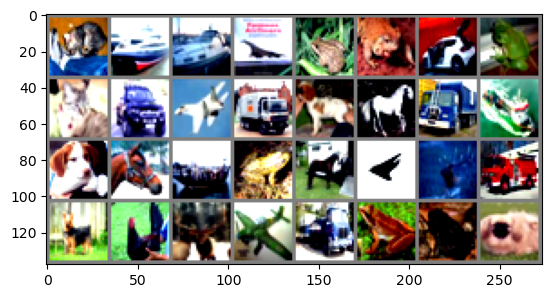

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images[:32]))


In [ ]:
# This cell is from the website

lr = 4e-2
weight_decay = 1e-4
epochs = 100
best_prec = 0
train_loss = []

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')
    
fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss.append(train(trainloader, model, criterion, optimizer, epoch))
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    
plt.plot(train_loss, label='train loss')
    

In [ ]:
fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)

In [ ]:
# HW

#  1. train resnet20 and vgg16 to achieve >90% accuracy 
#  2. save your trained model in the result folder 
#  3. Restart your jupyter notebook by "Kernel - Restart & Clear Output"
#  4. Load your saved model for vgg16 and validate to see the accuracy
#  5. such as the last part of "[W2S2_example2]_CNN_for_MNIST.ipynb", prehook the input layers of all the conv layers.
#  6. from the first prehooked input, compute to get the second prehooked input. 
#  7. Compare your computed second input vs. the prehooked second input.

### Part I

#### ResNet20 Training

In [ ]:
model_name = "resnet20_cifar"
model = resnet20_cifar()

lr = 3e-2
weight_decay = 5e-4
epochs = 150
best_prec = 0
train_loss_resnet20 = []

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')
    
fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss_resnet20.append(train(trainloader, model, criterion, optimizer, epoch))
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    
plt.plot(train_loss_resnet20, label='train loss')

In [69]:
# test accuracy of resnet20
model = resnet20_cifar()
model_name = "resnet20_cifar"

fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)

model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)

Test: [0/40]	Time 3.487 (3.487)	Loss 0.3063 (0.3063)	Prec 93.359% (93.359%)
Test: [5/40]	Time 0.005 (0.608)	Loss 0.3016 (0.3523)	Prec 91.797% (91.016%)
Test: [10/40]	Time 0.010 (0.334)	Loss 0.3038 (0.3494)	Prec 90.234% (90.625%)
Test: [15/40]	Time 0.006 (0.232)	Loss 0.4128 (0.3614)	Prec 90.625% (90.332%)
Test: [20/40]	Time 0.011 (0.179)	Loss 0.2937 (0.3498)	Prec 91.016% (90.718%)
Test: [25/40]	Time 0.004 (0.146)	Loss 0.3392 (0.3495)	Prec 89.453% (90.760%)
Test: [30/40]	Time 0.008 (0.124)	Loss 0.3565 (0.3477)	Prec 88.672% (90.801%)
Test: [35/40]	Time 0.012 (0.108)	Loss 0.2750 (0.3452)	Prec 90.234% (90.668%)
 * Prec 90.730% 


#### VGG16 Training

In [ ]:
model_name = 'vgg16_cifar'
model = VGG16()

lr = 3e-2
weight_decay = 5e-4
epochs = 150
best_prec = 0
train_loss_resnet20 = []

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')
    
fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss_resnet20.append(train(trainloader, model, criterion, optimizer, epoch))
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    
plt.plot(train_loss_resnet20, label='train loss')

In [70]:
# test accuracy of vgg16
model = VGG16()
model_name = 'vgg16_cifar'

fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)

Test: [0/40]	Time 3.545 (3.545)	Loss 0.1493 (0.1493)	Prec 96.484% (96.484%)
Test: [5/40]	Time 0.006 (0.596)	Loss 0.2983 (0.3106)	Prec 93.359% (93.555%)
Test: [10/40]	Time 0.008 (0.329)	Loss 0.4252 (0.3454)	Prec 92.188% (92.969%)
Test: [15/40]	Time 0.010 (0.229)	Loss 0.4787 (0.3617)	Prec 91.797% (92.798%)
Test: [20/40]	Time 0.010 (0.176)	Loss 0.3234 (0.3620)	Prec 92.578% (92.634%)
Test: [25/40]	Time 0.007 (0.144)	Loss 0.3015 (0.3533)	Prec 92.969% (92.788%)
Test: [30/40]	Time 0.009 (0.122)	Loss 0.3695 (0.3543)	Prec 91.797% (92.729%)
Test: [35/40]	Time 0.018 (0.107)	Loss 0.3043 (0.3541)	Prec 93.359% (92.719%)
 * Prec 92.760% 


### Part II

In [71]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
    def __call__(self, module, module_in):
        self.outputs.append(module_in)
    def clear(self):
        self.outputs = []  
        
######### Save inputs from selected layer ##########

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.to('cuda')

#### VGG16 Pre-hooking

In [77]:
save_output_vgg = SaveOutput()

model = VGG16().to('cuda')
model_name = 'vgg16_cifar'
fdir = 'result/'+str(model_name)+'/model_best.pth.tar'
checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])

for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
        # print("prehooked")
        layer.register_forward_pre_hook(save_output_vgg)       ## Input for the module will be grapped
       
####################################################

out = model(images)
# print("1st convolution's input size:", save_output.outputs[0][0].size()) # (batch_size, channel, height, width)
# print("2nd convolution's input size:", save_output.outputs[1][0].size())

In [80]:
input_tensor = save_output_vgg.outputs[0][0]

conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False).to('cuda')
bn1 = nn.BatchNorm2d(64).to('cuda')
relu1 = nn.ReLU(inplace=True).to('cuda')

conv1_weight = model.features[0].weight.data
conv1.bias = model.features[0].bias.data if model.features[0].bias is not None else None
bn1_weight = model.features[1].weight.data
bn1_bias = model.features[1].bias.data
bn1_running_mean = model.features[1].running_mean
bn1_running_var = model.features[1].running_var
conv1.weight.data = conv1_weight.clone()
bn1.weight.data = bn1_weight.clone()
bn1.bias.data = bn1_bias.clone()
bn1.running_mean = bn1_running_mean.clone()
bn1.running_var = bn1_running_var.clone()

output_tensor = conv1(input_tensor)
output_tensor = bn1(output_tensor)
output_tensor = relu1(output_tensor)

print(torch.allclose(output_tensor, save_output_vgg.outputs[1][0], atol=1e-6, rtol=1e-4))
print(F.mse_loss(output_tensor, save_output_vgg.outputs[1][0]))

True
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)


#### ResNet20 Pre-hooking

In [74]:
save_output_resnet = SaveOutput()

model = resnet20_cifar().to('cuda')
model_name = 'resnet20_cifar'
fdir = 'result/'+str(model_name)+'/model_best.pth.tar'
checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])

for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
        # print("prehooked")
        layer.register_forward_pre_hook(save_output_resnet)       ## Input for the module will be grapped       
####################################################

out = model(images)
# hook_handle = model.layer1[0].conv1.register_forward_pre_hook(save_output)
# print("1st convolution's input size:", save_output_resnet.outputs[0][0].size()) # (batch_size, channel, height, width)
# print("2nd convolution's input size:", save_output_resnet.outputs[1][0].size())

print(model)

ResNet_Cifar(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [76]:
input_tensor = save_output_resnet.outputs[1][0]

conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False).to('cuda')
bn1 = nn.BatchNorm2d(16).to('cuda')
relu = nn.ReLU(inplace=True).to('cuda')
conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False).to('cuda')
bn2 = nn.BatchNorm2d(16).to('cuda')

basic_block = model.layer1[0]
conv1.weight.data = basic_block.conv1.weight.data.clone()
bn1.weight.data = basic_block.bn1.weight.data.clone()
bn1.bias.data = basic_block.bn1.bias.data.clone()
bn1.running_mean = basic_block.bn1.running_mean.clone()
bn1.running_var = basic_block.bn1.running_var.clone()
conv2.weight.data = basic_block.conv2.weight.data.clone()
bn2.weight.data = basic_block.bn2.weight.data.clone()
bn2.bias.data = basic_block.bn2.bias.data.clone()
bn2.running_mean = basic_block.bn2.running_mean.clone()
bn2.running_var = basic_block.bn2.running_var.clone()

residual = input_tensor
output_tensor = conv1(input_tensor)
output_tensor = bn1(output_tensor)
output_tensor = relu(output_tensor)
output_tensor = conv2(output_tensor)
output_tensor = bn2(output_tensor)

if basic_block.downsample:
    residual = basic_block.downsample(input_tensor)
output_tensor += residual
output_tensor = relu(output_tensor)

print(torch.allclose(output_tensor, save_output_resnet.outputs[3][0], atol=1e-6, rtol=1e-4))
print(F.mse_loss(output_tensor, save_output_resnet.outputs[3][0], reduction='sum'))

True
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)


I followed the ResNet20 architecture defined in "resnet.py", specifically the BasicBlock class, and reconstructed the BasicBlock0 part of the whole Resnet20. The manual calculation with prehooked inputs agrees with the forward propagation results.